In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.patches import Patch

In [55]:
#path where you stored your copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')
dataset_file = 'train_v1.0-trainval_lidar_0.csv'

## Data Analysis


The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

Load the CSV data into a DataFrame


In [56]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'yaw_rate': 'float64'
}
nuscenes_df = pd.read_csv(DATAROOT / dataset_file, dtype=dtype_dict, parse_dates=['timestamp'])

nuscenes_df.head()

,sample_token,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,acceleration,yaw_rate
0,3481dbfd65864925b4a4b2d6b7256d44,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:29.048702,"[0.27668389210179944, -0.0026796705507768723, ...",427.968583,1622.155828,0.0,2.580930,0.000004,NaN,0.000033
1,394d87634b6c46049c2f06e84026096a,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:29.548597,"[0.27667585323668453, -0.002728894247491543, 0...",427.968582,1622.155829,0.0,2.580947,0.000004,NaN,0.000033
2,656b4207ba9542b2a9bb7c03aa61b325,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:30.048445,"[0.2766247744031405, -0.0027369692279543625, 0...",427.968589,1622.155824,0.0,2.581053,0.000018,0.000028,0.000212
3,2f789ae558a84df9b8daee0674a7985f,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:30.548859,"[0.27663215946727443, -0.002737971665731827, 0...",427.968593,1622.155822,0.0,2.581038,0.000008,-0.000020,-0.000031
4,623e58c15be546b39a36796a5b03d18f,0053e9c440a94c1b84bd9c4223efc4b0,0.178096,boston-seaport,lidar,2018-07-27 16:20:31.048731,"[0.27662503731230986, -0.002729398219646146, 0...",427.968591,1622.155823,0.0,2.581052,0.000004,-0.000008,0.000029


In [57]:
nuscenes_df.shape

(26848, 14)

## Extract Relevant Annotated Data from DriveLM

For DriveLM-nuScenes, we divide the annotation process into three steps:

1️⃣ Keyframe selection. Given all frames in one clip, the annotator selects the keyframes that need annotation. The criterion is that those frames should involve changes in ego-vehicle movement status (lane changes, sudden stops, start after a stop, etc.).

2️⃣ Key objects selection. Given keyframes, the annotator needs to pick up key objects in the six surrounding images. The criterion is that those objects should be able to affect the action of the ego vehicle (traffic signals, pedestrians crossing the road, other vehicles that move in the direction of the ego vehicle, etc.).

3️⃣ Question and answer annotation. Given those key objects, we automatically generate questions regarding single or multiple objects about perception, prediction, and planning. More details can be found in our data.

Ref: https://github.com/OpenDriveLab/DriveLM/blob/data_release/docs/data_details.md

In [58]:
# Function to extract relevant information and create dataframe
def extract_behavior_data(data):
    behavior_data = []
    for scene_token, scene_info in data.items():
        for key_frame_token, key_frame_info in scene_info.get("key_frames", {}).items():
            behavior_info = key_frame_info.get("QA", {}).get("behavior", [])
            for behavior in behavior_info:
                behavior_str = behavior.get("A")
                steering_angle, speed,_ = behavior_str.split('.')
                behavior_data.append({
                    "scene_token": scene_token,
                    "key_frame_token": key_frame_token,
                    #"behavior": behavior_str,
                    "steering_label": steering_angle,#.replace('The ego vehicle is going ', '').strip(),
                    "velocity_label": speed#.strip('fast.')
                })
    return pd.DataFrame(behavior_data)

# Create dataframe

drivelm_df = pd.read_json('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/drivelm/v1_1_train_nus.json')
behavior_df = extract_behavior_data(drivelm_df)

# Display dataframe
behavior_df.head()

,scene_token,key_frame_token,steering_label,velocity_label
0,f0f120e4d4b0441da90ec53b16ee169d,4a0798f849ca477ab18009c3a20b7df2,The ego vehicle is going straight,The ego vehicle is driving fast
1,f0f120e4d4b0441da90ec53b16ee169d,ffd1bdf020d145759224c629b501d2b2,The ego vehicle is going straight,The ego vehicle is driving slowly
2,f0f120e4d4b0441da90ec53b16ee169d,d9075c2a5f864a2b8abf41e703f4cf1c,The ego vehicle is going straight,The ego vehicle is driving slowly
3,f0f120e4d4b0441da90ec53b16ee169d,dfb8d8959b9944d69dcec6d05e419f04,The ego vehicle is going straight,The ego vehicle is driving fast
4,54cdaaae372d421fa4734d66f51a8c48,542eaf1fc9b34895a9e55fab57cb4cf4,The ego vehicle is going straight,The ego vehicle is driving slowly


Given the selection strategy of the scenes, we check all the scenes included in DriveLM and exclude the one that are not in our train set. This means their are in the test set, and we do not want to include test information during training. 

In [59]:
drivelm_scenes = behavior_df['scene_token'].unique()
print(f'In DriveLM dataset there are {len(drivelm_scenes)} scenes.')


In DriveLM dataset there are 696 scenes.


In [60]:
nuscenes_train_scenes = nuscenes_df['scene_token'].unique()
print(f'In our split of nuScenes there are {len(nuscenes_train_scenes)} scenes for the Train Set and {1000-150-15-len(nuscenes_train_scenes)} for the Test Set.')

In our split of nuScenes there are 668 scenes for the Train Set and 167 for the Test Set.


In [61]:
scenes_only_in_drivelm = list(set(drivelm_scenes) - set(nuscenes_train_scenes))

print(f'In DriveLM dataset there are {len(scenes_only_in_drivelm)} scenes from our Test Set.')
print(f'we exclude them to avoid including testing information during training.')

In DriveLM dataset there are 150 scenes from our Test Set.
we exclude them to avoid including testing information during training.


Delete nuScenes testing data from DriveLM

In [62]:
# Filter the dataframe to exclude these scenes
drivelm_filtered = behavior_df[~behavior_df['scene_token'].isin(scenes_only_in_drivelm)]
len(drivelm_filtered['scene_token'].unique())

546

### Steering Angle Discretization 

Merge steering angle information from NuScenes to the human annotated label (straight, right, slight right, left, slight left) from DriveLm, on the 'sample_token' field


In [63]:
can_df = pd.read_csv(DATAROOT / 'can_data.csv')[['sample_token','steering_angle']]
merged_df = pd.merge(drivelm_filtered, can_df, left_on='key_frame_token', right_on='sample_token', how='inner')#.drop(columns=['location', 'sample_token', 'scene_token_y'])


/tmp/ipykernel_223584/1772303425.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='steering_angle', y='steering_label', data=merged_df, palette='Set3')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


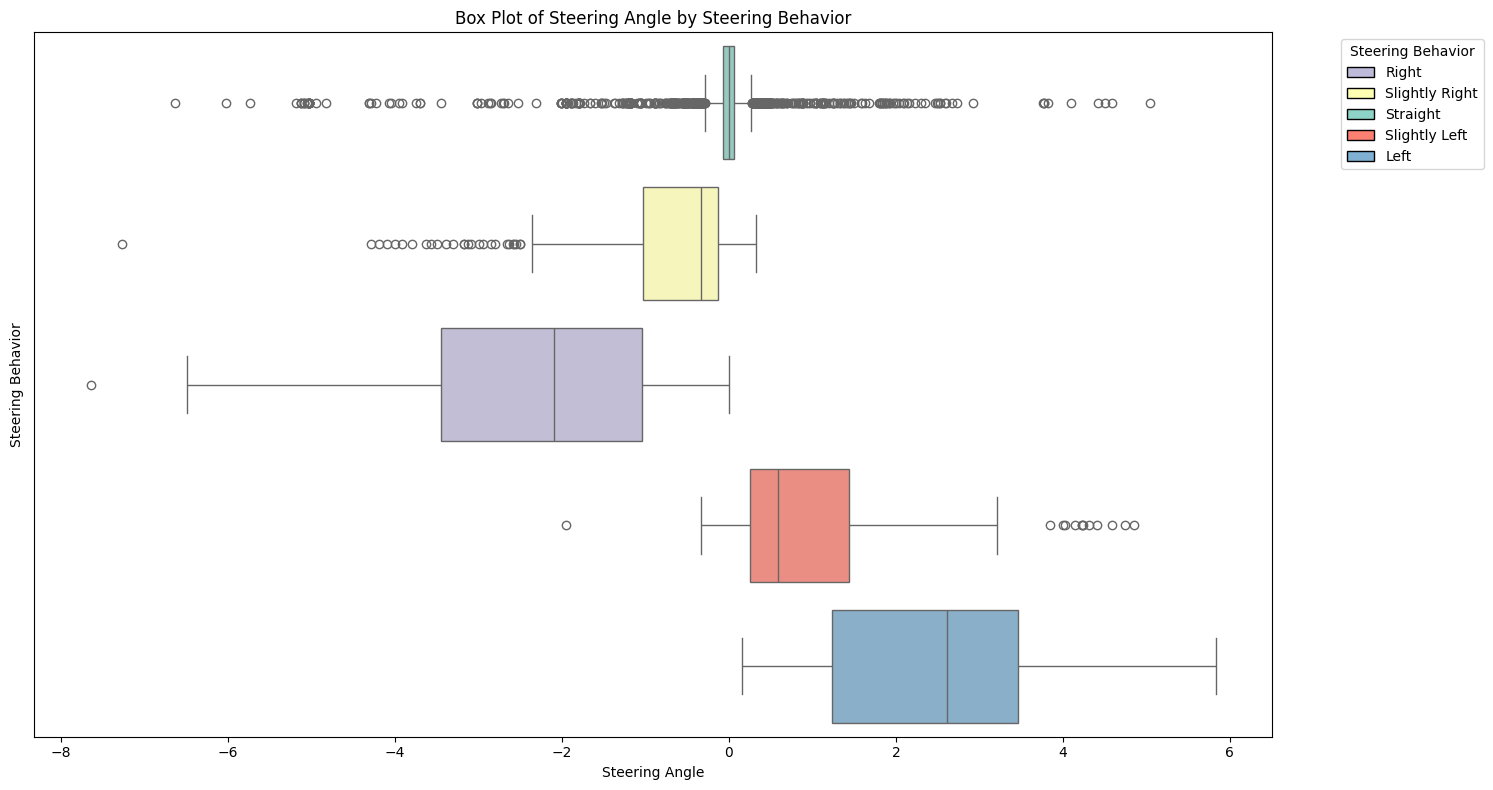

In [64]:
# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='steering_angle', y='steering_label', data=merged_df, palette='Set3')

#create legend
plt.legend(title='Steering Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a legend
legend_elements = [
    Patch(facecolor=sns.color_palette('Set3')[2], edgecolor='black', label='Right'),
    Patch(facecolor=sns.color_palette('Set3')[1], edgecolor='black', label='Slightly Right'),
    Patch(facecolor=sns.color_palette('Set3')[0], edgecolor='black', label='Straight'),
    Patch(facecolor=sns.color_palette('Set3')[3], edgecolor='black', label='Slightly Left'),
    Patch(facecolor=sns.color_palette('Set3')[4], edgecolor='black', label='Left')
    
]

plt.legend(handles=legend_elements, title='Steering Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')


# Set plot title and labels
plt.title('Box Plot of Steering Angle by Steering Behavior')
plt.xlabel('Steering Angle')
plt.ylabel('Steering Behavior')
plt.yticks([])

# Display the plot
plt.tight_layout()
plt.show()

In [65]:
# Group the data by steering angle and calculate IQR for each group
#note: we exclude outliers
def get_whiskers(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = max(x.min(), Q1 - 1.5 * IQR)
    upper_whisker = min(x.max(), Q3 + 1.5 * IQR)
    return (lower_whisker, upper_whisker)

iqr_per_steering_angle = merged_df.groupby('steering_label')['steering_angle'].apply(get_whiskers)
# Display the calculated IQR for each steering angle
print(iqr_per_steering_angle)


steering_label
The ego vehicle is going straight                    (-0.2867895294676068, 0.27338918491059877)
The ego vehicle is slightly steering to the left       (-1.5175817784870558, 3.215895103945492)
The ego vehicle is slightly steering to the right     (-2.3987751180862764, 0.3229578871309232)
The ego vehicle is steering to the left                 (0.1605702911834831, 5.832962335677019)
The ego vehicle is steering to the right               (-7.059964787585022, 0.0052359877559861)
Name: steering_angle, dtype: object


thresholds = [-7.059964787585022, -2.3987751180862764, -0.2867895294676068, 0.27338918491059877, 3.215895103945492, 5.832962335677019]

### Velocity Discretization

Merge speed information from NuScenes to the human annotated label ('not moving', 'slow', 'normal', 'fast', 'very fast') from DriveLm, on the 'sample_token' field


In [66]:
velocity_df = nuscenes_df[['sample_token','velocity']]
merged_df = pd.merge(drivelm_filtered, velocity_df, left_on='key_frame_token', right_on='sample_token', how='inner')


/tmp/ipykernel_223584/3579792000.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='velocity', y='velocity_label', data=merged_df, palette='Set3')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


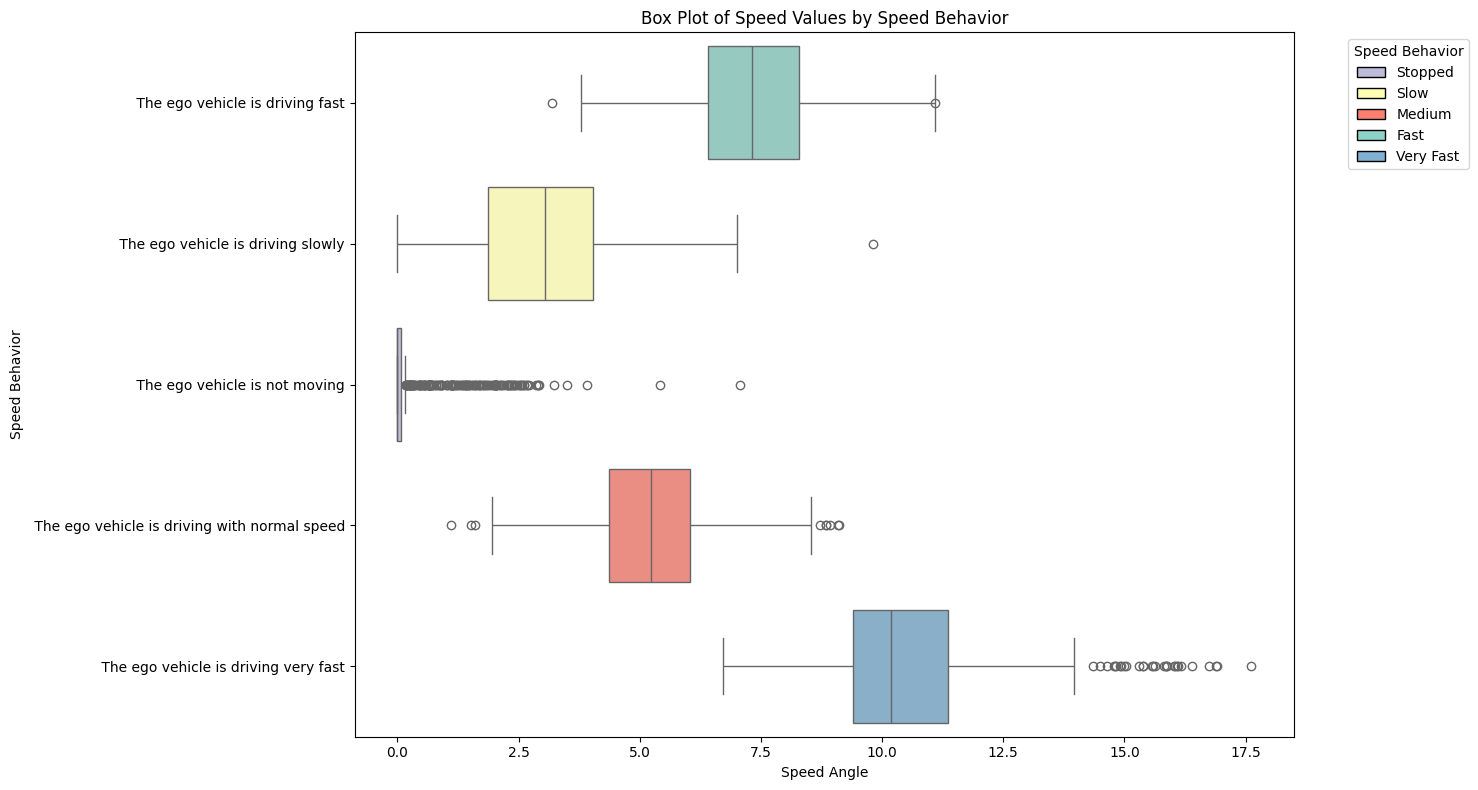

In [67]:
# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='velocity', y='velocity_label', data=merged_df, palette='Set3')

#create legend
plt.legend(title='Speed Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a legend
legend_elements = [
    Patch(facecolor=sns.color_palette('Set3')[2], edgecolor='black', label='Stopped'),
    Patch(facecolor=sns.color_palette('Set3')[1], edgecolor='black', label='Slow'),
    Patch(facecolor=sns.color_palette('Set3')[3], edgecolor='black', label='Medium'),
    Patch(facecolor=sns.color_palette('Set3')[0], edgecolor='black', label='Fast'),
    Patch(facecolor=sns.color_palette('Set3')[4], edgecolor='black', label='Very Fast')
    
]

plt.legend(handles=legend_elements, title='Speed Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')


# Set plot title and labels
plt.title('Box Plot of Speed Values by Speed Behavior')
plt.xlabel('Speed Angle')
plt.ylabel('Speed Behavior')
#plt.yticks([])

# Display the plot
plt.tight_layout()
plt.show()

In [68]:
iqr_per_velocity = merged_df.groupby('velocity_label')['velocity'].apply(get_whiskers)
# Display the calculated IQR for each velocity label
print(iqr_per_velocity)

velocity_label
 The ego vehicle is driving fast                     (3.5982759592782734, 11.087233438147942)
 The ego vehicle is driving slowly                (3.4960907241385346e-07, 7.269930491687321)
 The ego vehicle is driving very fast                 (6.711242928541665, 14.274223926233333)
 The ego vehicle is driving with normal speed          (1.8710851866181795, 8.54211115685087)
 The ego vehicle is not moving                   (5.947235439243747e-09, 0.16630834573952916)
Name: velocity, dtype: object


threshold =  [0.16630834573952916, 7.269930491687321, 8.54211115685087, 11.087233438147942,  14.274223926233333]

## Action Extraction 

In [69]:
dynamics_df = nuscenes_df[['sample_token','velocity', 'acceleration','yaw_rate']]
merged_df = pd.merge(drivelm_filtered, dynamics_df, left_on='key_frame_token', right_on='sample_token', how='inner')
merged_df = pd.merge(merged_df, can_df, left_on='key_frame_token', right_on='sample_token', how='inner')#.drop(columns=['location', 'sample_token', 'scene_token_y'])
merged_df.columns

Index(['scene_token', 'key_frame_token', 'steering_label', 'velocity_label',
       'sample_token_x', 'velocity', 'acceleration', 'yaw_rate',
       'sample_token_y', 'steering_angle'],
      dtype='object')

/tmp/ipykernel_223584/114407796.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='velocity', y='steering_label', data=merged_df, palette='Set3')
/tmp/ipykernel_223584/114407796.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='steering_angle', y='steering_label', data=merged_df, palette='Set3')
/tmp/ipykernel_223584/114407796.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='acceleration', y='steering_label', data=merged_df, palette='Set3')
/tmp/ipykernel_223584/114407796.py:38: UserWarning: Tight layout not applied. tight_l

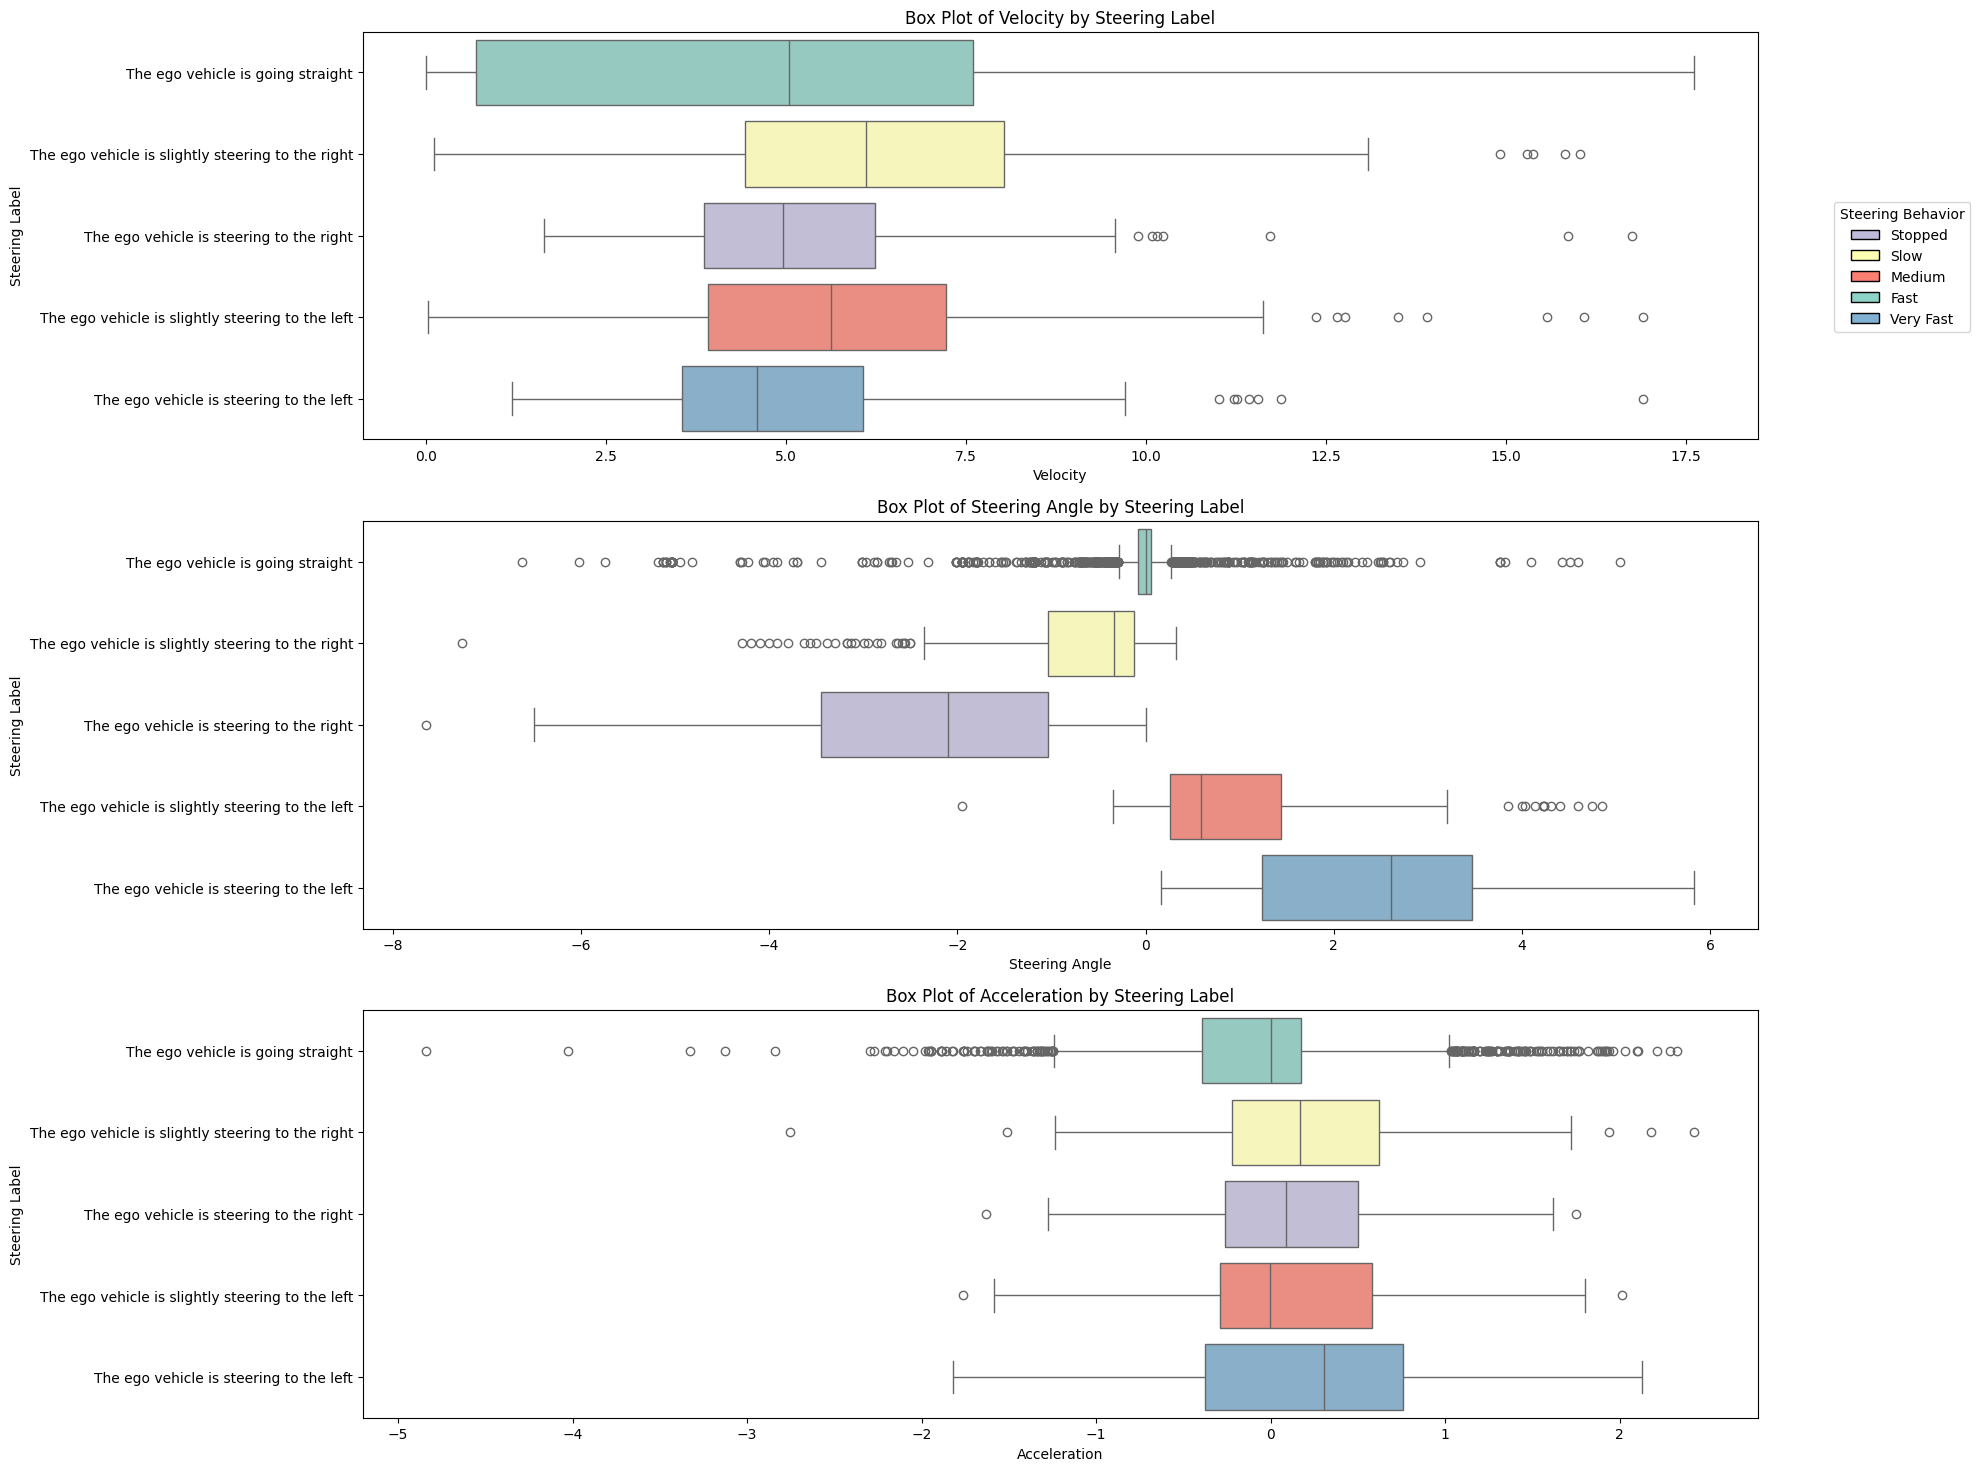

In [70]:
# Create the box plots for each column with 'steering label' as the hue
plt.figure(figsize=(18, 18))

# Velocity box plot
plt.subplot(3, 1, 1)
sns.boxplot(x='velocity', y='steering_label', data=merged_df, palette='Set3')
plt.title('Box Plot of Velocity by Steering Label')
plt.xlabel('Velocity')
plt.ylabel('Steering Label')

# Yaw Rate box plot
plt.subplot(3, 1, 2)
sns.boxplot(x='steering_angle', y='steering_label', data=merged_df, palette='Set3')
plt.title('Box Plot of Steering Angle by Steering Label')
plt.xlabel('Steering Angle')
plt.ylabel('Steering Label')

# Acceleration box plot
plt.subplot(3, 1, 3)
sns.boxplot(x='acceleration', y='steering_label', data=merged_df, palette='Set3')
plt.title('Box Plot of Acceleration by Steering Label')
plt.xlabel('Acceleration')
plt.ylabel('Steering Label')

# Create a legend
legend_elements = [
    Patch(facecolor=sns.color_palette('Set3')[2], edgecolor='black', label='Stopped'),
    Patch(facecolor=sns.color_palette('Set3')[1], edgecolor='black', label='Slow'),
    Patch(facecolor=sns.color_palette('Set3')[3], edgecolor='black', label='Medium'),
    Patch(facecolor=sns.color_palette('Set3')[0], edgecolor='black', label='Fast'),
    Patch(facecolor=sns.color_palette('Set3')[4], edgecolor='black', label='Very Fast')
]

# Add legend outside the plot
plt.legend(handles=legend_elements, title='Steering Behavior', bbox_to_anchor=(1.05, 3), loc='upper left')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [71]:
merged_df.groupby('steering_label')['steering_angle'].apply(get_whiskers)

steering_label
The ego vehicle is going straight                    (-0.2867895294676068, 0.27338918491059877)
The ego vehicle is slightly steering to the left       (-1.5175817784870558, 3.215895103945492)
The ego vehicle is slightly steering to the right     (-2.3987751180862764, 0.3229578871309232)
The ego vehicle is steering to the left                 (0.1605702911834831, 5.832962335677019)
The ego vehicle is steering to the right               (-7.059964787585022, 0.0052359877559861)
Name: steering_angle, dtype: object

eps_rot_l: 0.27338918491059877
eps_rot_r: -0.2867895294676068

/tmp/ipykernel_223584/791636707.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='velocity', y='velocity_label', data=merged_df, palette='Set3')
/tmp/ipykernel_223584/791636707.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='steering_angle', y='velocity_label', data=merged_df, palette='Set3')
/tmp/ipykernel_223584/791636707.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='acceleration', y='velocity_label', data=merged_df, palette='Set3')
/tmp/ipykernel_223584/791636707.py:38: UserWarning: Tight layout not applied. tight_l

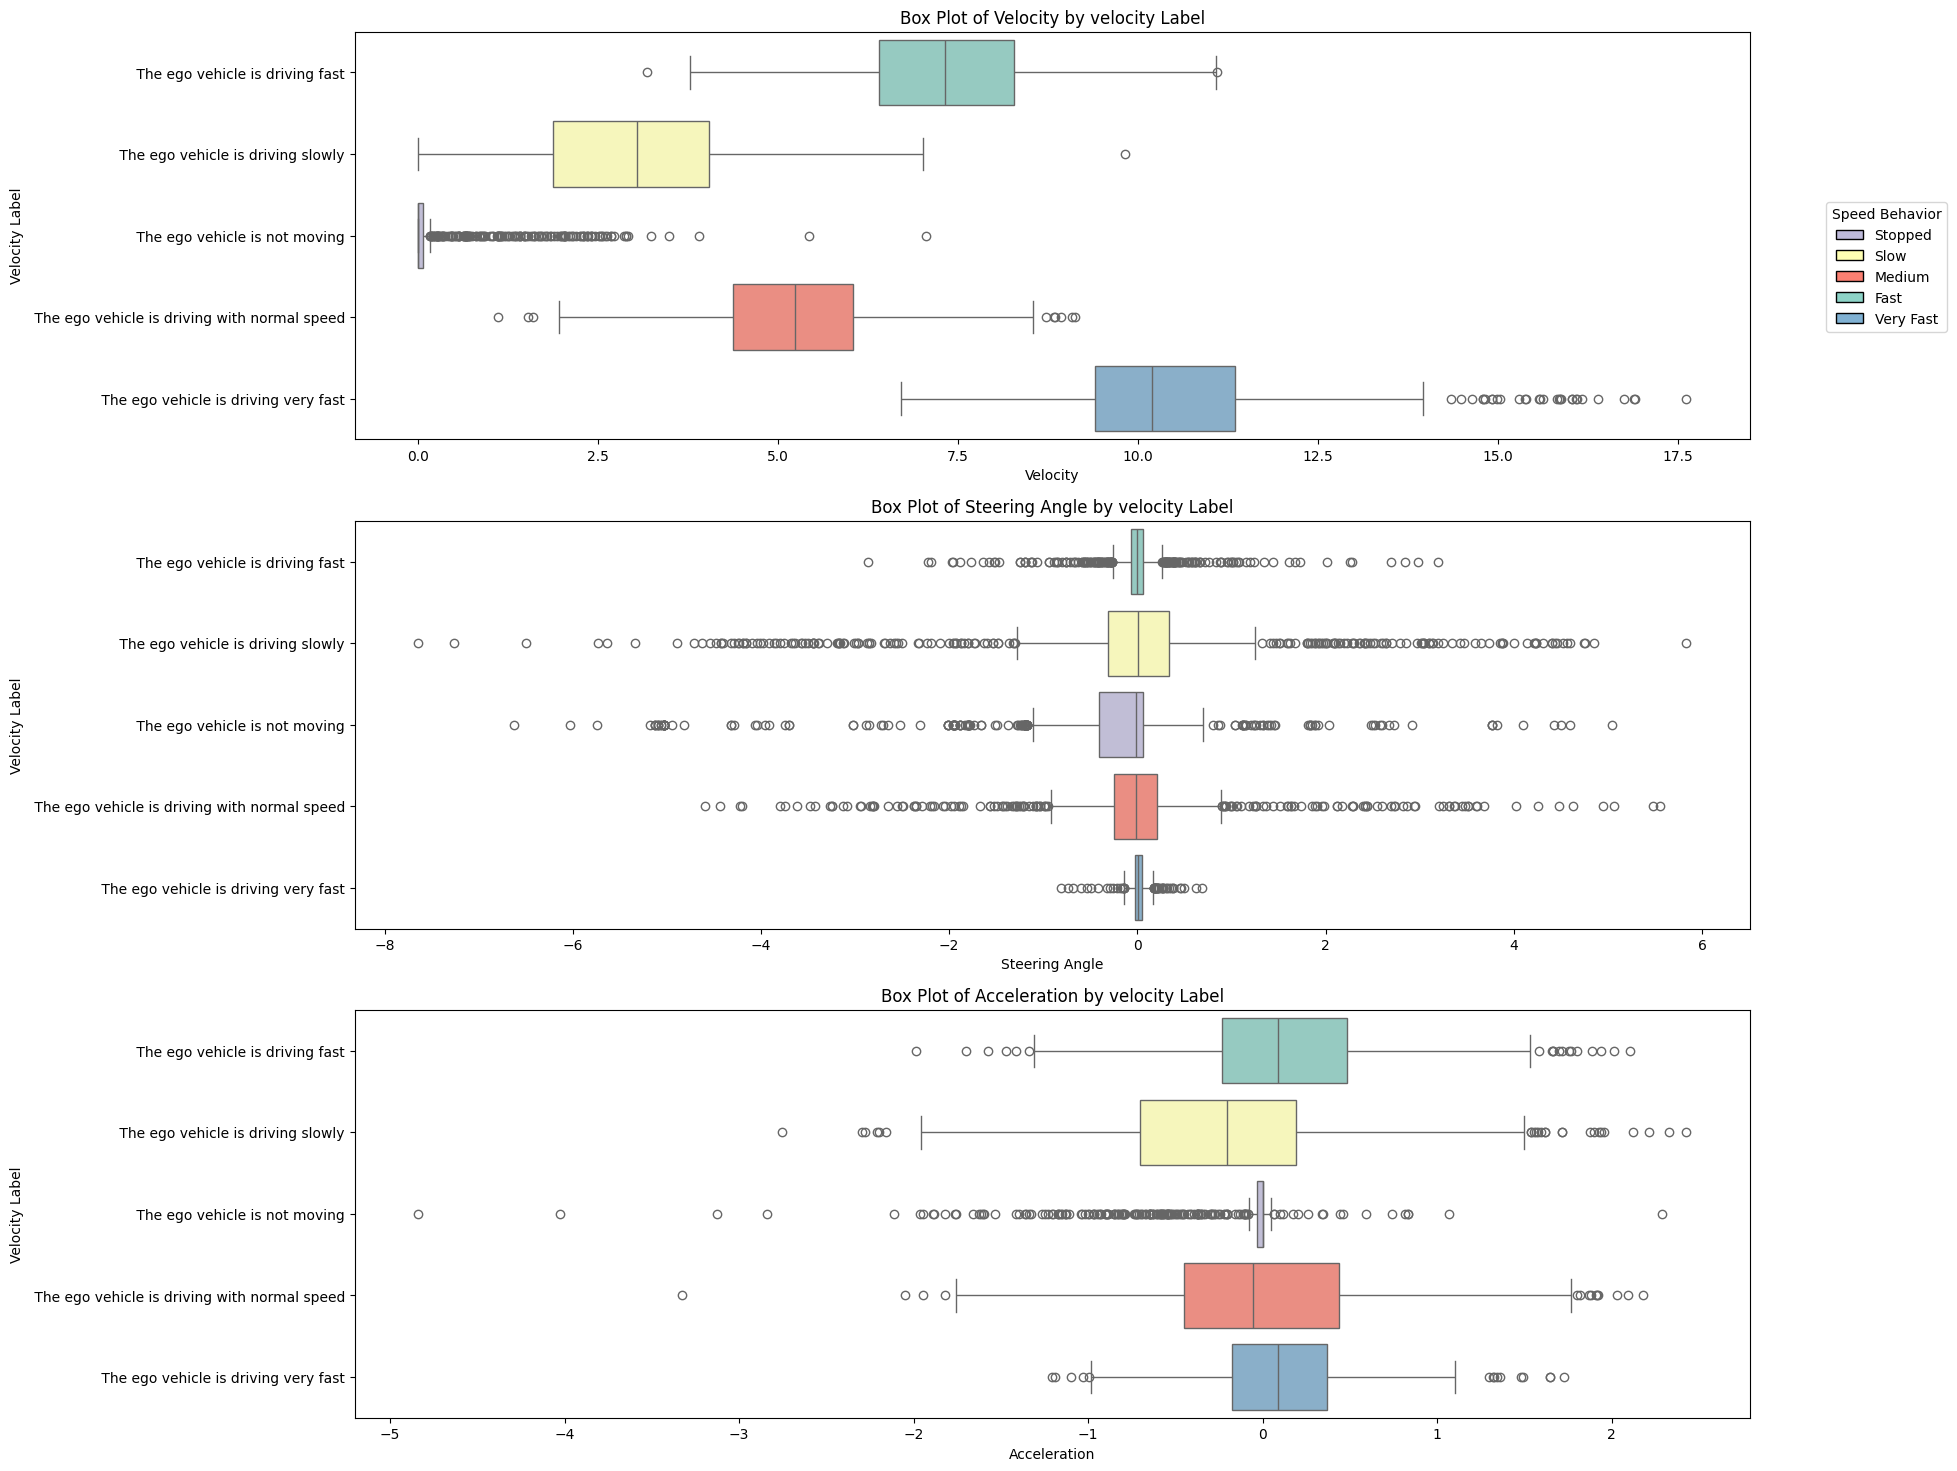

In [72]:
# Create the box plots for each column with 'steering label' as the hue
plt.figure(figsize=(18, 18))

# Velocity box plot
plt.subplot(3, 1, 1)
sns.boxplot(x='velocity', y='velocity_label', data=merged_df, palette='Set3')
plt.title('Box Plot of Velocity by velocity Label')
plt.xlabel('Velocity')
plt.ylabel('Velocity Label')

# Yaw Rate box plot
plt.subplot(3, 1, 2)
sns.boxplot(x='steering_angle', y='velocity_label', data=merged_df, palette='Set3')
plt.title('Box Plot of Steering Angle by velocity Label')
plt.xlabel('Steering Angle')
plt.ylabel('Velocity Label')

# Acceleration box plot
plt.subplot(3, 1, 3)
sns.boxplot(x='acceleration', y='velocity_label', data=merged_df, palette='Set3')
plt.title('Box Plot of Acceleration by velocity Label')
plt.xlabel('Acceleration')
plt.ylabel('Velocity Label')

# Create a legend
legend_elements = [
    Patch(facecolor=sns.color_palette('Set3')[2], edgecolor='black', label='Stopped'),
    Patch(facecolor=sns.color_palette('Set3')[1], edgecolor='black', label='Slow'),
    Patch(facecolor=sns.color_palette('Set3')[3], edgecolor='black', label='Medium'),
    Patch(facecolor=sns.color_palette('Set3')[0], edgecolor='black', label='Fast'),
    Patch(facecolor=sns.color_palette('Set3')[4], edgecolor='black', label='Very Fast')
]

# Add legend outside the plot
plt.legend(handles=legend_elements, title='Speed Behavior', bbox_to_anchor=(1.05, 3), loc='upper left')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [73]:
merged_df.groupby('velocity_label')['velocity'].apply(get_whiskers)

velocity_label
 The ego vehicle is driving fast                     (3.5982759592782734, 11.087233438147942)
 The ego vehicle is driving slowly                (3.4960907241385346e-07, 7.269930491687321)
 The ego vehicle is driving very fast                 (6.711242928541665, 14.274223926233333)
 The ego vehicle is driving with normal speed          (1.8710851866181795, 8.54211115685087)
 The ego vehicle is not moving                   (5.947235439243747e-09, 0.16630834573952916)
Name: velocity, dtype: object

Threshold for eps_vel: 0.16630834573952916

In [74]:
merged_df.groupby('velocity_label')['acceleration'].apply(get_whiskers)

velocity_label
 The ego vehicle is driving fast                  (-1.3137769486914987, 1.565187198305411)
 The ego vehicle is driving slowly                 (-2.03542039743286, 1.5239963713246067)
 The ego vehicle is driving very fast            (-0.9939819108703826, 1.1911302890131064)
 The ego vehicle is driving with normal speed    (-1.7886339521958603, 1.7730977421466254)
 The ego vehicle is not moving                   (-0.0789963968860624, 0.0473958911578244)
Name: acceleration, dtype: object

Threshold for eps_acc: 0.0473958911578244